# Personal Model

*With this notebook we try a new personal model. The goal of this "personal" model, is to have a more hand-on work and try to adjust parameters manually. By transforming the Difficulty levels into numeric values, we can try to compute feature values and through them, compute a new score for each sentence.*

In this second notebook we do some additional feature adjustements and some more preprocessing.
The feature we add to this version is the Readability score, thanks to the textstat module that can give a readability score to a sentence on its own.
We will need to adjust it for our purpose however

Here we use the train dataset provided on AICrowd. We have to reduce the number of sentence from 4800 to 1200 because of the dataset being too big and heavy. We still keep an equal proportion per Category however.

### Installing and importing the necessary libraries and packages

In [ ]:
!pip install unidecode
!pip install textstat

In [ ]:
!pip install wordstats
!pip install nltk
!pip install spacy download fr
!spacy download fr_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [ ]:
!python3 -m spacy download fr_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [ ]:
import fr_core_news_sm

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
import string
from wordstats import Word, common_words
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('punkt')
import textstat
textstat.set_lang(lang="fr")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the train dataset provided on AICrowd

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/ahusejn1/TeamApple_Big_Scale_Analytics/main/Data/aicrowd/train.csv")

In [ ]:
df.head(5)

,sentence,difficulty
0,C'est pour quand ?,A1
1,Je pense que c'est bon.,A1
2,C'est pas mal.,A1
3,Qu'est-ce que vous faites ?,A1
4,C'est bien !,A1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence    4800 non-null   object
 1   difficulty  4800 non-null   object
dtypes: object(2)
memory usage: 75.1+ KB


### The dataset is too large and takes a lot of memory, so we decided to reduce it, from 4800 to 1200

The goal is to keep a still large enough dataset while keeping the same proportion for each category as the original dataset

In [ ]:
df = df.drop(range(4199,4799))

In [ ]:
df = df.drop(range(3399,3999))

In [ ]:
df = df.drop(range(2599,3199))

In [ ]:
df = df.drop(range(1799,2399))

In [ ]:
df = df.drop(range(999,1599))

In [ ]:
df = df.drop(range(199,799))

In [ ]:
df.rename({'sentence' : 'Text'}, axis=1, inplace=True)
df.rename({'difficulty' : 'Difficulty'}, axis=1, inplace=True)

In [ ]:
df.Text = df.Text.astype('str')

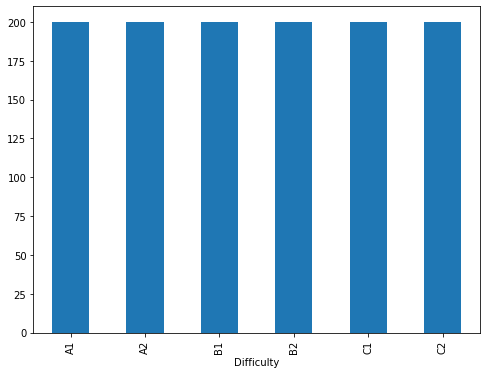

In [ ]:
fig = plt.figure(figsize=(8,6))
df.groupby('Difficulty').Text.count().plot.bar(ylim=0)
plt.show()

### Transform Categories into numeric values 

In [ ]:
df = df.replace(['A1', 'A2', 'B1', 'B2', 'C1', 'C2'], [1,2,3,4,5,6])

In [ ]:
df.head(10)

,Text,Difficulty
0,C'est pour quand ?,1
1,Je pense que c'est bon.,1
2,C'est pas mal.,1
3,Qu'est-ce que vous faites ?,1
4,C'est bien !,1
5,Ce n'est pas juste.,1
6,Je ne veux pas.,1
7,Je ne sais pas.,1
8,Plus que ça.,1
9,"Non, je ne le trouve pas !",1


## Feature augmentation
Separate the words, in order to get the difficulty per word

In [ ]:
df["Word"] = ""

In [ ]:
sp = fr_core_news_sm.load()
len = df.shape[0]
ligne = 0
while ligne<len:
  text = str(df["Text"].iloc[ligne])
  theDoc = sp(text)
  token_list = []
  new_List = []
  for w in theDoc:
    token_list.append(w.text)
    if (w.pos_ == "PROPN") or (w.pos_ == "NUM"):
      token_list.remove(w.text)
  df["Word"].iloc[ligne] = token_list
  ligne += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Get the types for each word

In [ ]:
df["Types"] = ""
line = 0
while line<len:
  my_list = []
  text = df['Text'].iloc[line]
  my_doc = sp(text)
  for w in my_doc: 
    my_list.append(w.pos_)
  df['Types'].iloc[line] = my_list
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.head(15)

,Text,Difficulty,Word,Types
0,C'est pour quand ?,1,"[C', est, pour, quand, ?]","[PRON, AUX, ADP, SCONJ, PUNCT]"
1,Je pense que c'est bon.,1,"[Je, pense, que, c', est, bon, .]","[PRON, VERB, SCONJ, PRON, AUX, ADJ, PUNCT]"
2,C'est pas mal.,1,"[C', est, pas, mal, .]","[PRON, AUX, ADV, ADV, PUNCT]"
3,Qu'est-ce que vous faites ?,1,"[Qu', est, -ce, que, vous, faites, ?]","[, , PRON, SCONJ, PRON, VERB, PUNCT]"
4,C'est bien !,1,"[C', est, bien, !]","[PRON, AUX, ADV, PUNCT]"
5,Ce n'est pas juste.,1,"[Ce, n', est, pas, juste, .]","[PRON, ADV, AUX, ADV, ADV, PUNCT]"
6,Je ne veux pas.,1,"[Je, ne, veux, pas, .]","[PRON, ADV, VERB, ADV, PUNCT]"
7,Je ne sais pas.,1,"[Je, ne, sais, pas, .]","[PRON, ADV, VERB, ADV, PUNCT]"
8,Plus que ça.,1,"[Plus, que, ça, .]","[ADV, SCONJ, PRON, PUNCT]"
9,"Non, je ne le trouve pas !",1,"[Non, ,, je, ne, le, trouve, pas, !]","[ADV, PUNCT, PRON, ADV, PRON, VERB, ADV, PUNCT]"


In [ ]:
df["WordDifficulty"] = ""
df["AvgWordDiffic"] = ""

In [ ]:
df.head(10)

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic
0,C'est pour quand ?,1,"[C', est, pour, quand, ?]","[PRON, AUX, ADP, SCONJ, PUNCT]",,
1,Je pense que c'est bon.,1,"[Je, pense, que, c', est, bon, .]","[PRON, VERB, SCONJ, PRON, AUX, ADJ, PUNCT]",,
2,C'est pas mal.,1,"[C', est, pas, mal, .]","[PRON, AUX, ADV, ADV, PUNCT]",,
3,Qu'est-ce que vous faites ?,1,"[Qu', est, -ce, que, vous, faites, ?]","[, , PRON, SCONJ, PRON, VERB, PUNCT]",,
4,C'est bien !,1,"[C', est, bien, !]","[PRON, AUX, ADV, PUNCT]",,
5,Ce n'est pas juste.,1,"[Ce, n', est, pas, juste, .]","[PRON, ADV, AUX, ADV, ADV, PUNCT]",,
6,Je ne veux pas.,1,"[Je, ne, veux, pas, .]","[PRON, ADV, VERB, ADV, PUNCT]",,
7,Je ne sais pas.,1,"[Je, ne, sais, pas, .]","[PRON, ADV, VERB, ADV, PUNCT]",,
8,Plus que ça.,1,"[Plus, que, ça, .]","[ADV, SCONJ, PRON, PUNCT]",,
9,"Non, je ne le trouve pas !",1,"[Non, ,, je, ne, le, trouve, pas, !]","[ADV, PUNCT, PRON, ADV, PRON, VERB, ADV, PUNCT]",,


In [ ]:
line = 0 
len = df.shape[0]
while line<len:
  newList = []
  for w in df.Word.iloc[line]:
    newList.append(Word.stats(w, "fr").difficulty)
  df.WordDifficulty.iloc[line] = newList
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# Get the average word difficulty
line = 0 
len = df.shape[0]
while line<len:
  total = 0
  nb = 0
  for i in df.WordDifficulty.iloc[line]:
    total += i
    nb += 1
    df.AvgWordDiffic.iloc[line] = total/nb 
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Preprocessing - remove punctuation

In [ ]:
punct = string.punctuation

In [ ]:
line = 0 
len = df.shape[0]
while line<len:
  diffic = df.Word.iloc[line]
  for i in diffic:
    if (i in punct):
      diffic.remove(i)
  line += 1

In [ ]:
df.tail(10)

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic
4190,Les arêtes de ce réseau sont les chemins parco...,6,"[Les, arêtes, de, ce, réseau, sont, les, chemi...","[DET, NOUN, ADP, DET, NOUN, AUX, DET, NOUN, AD...","[0.0, 1, 0.0, 0.0, 0.05, 0.0, 0.0, 0.1, 1, 1, ...",0.409302
4191,Ils venaient se délasser dans les beaux-arts d...,6,"[Ils, venaient, se, délasser, dans, les, beaux...","[PRON, NOUN, PRON, VERB, ADP, DET, NOUN, PUNCT...","[0.0, 0.1, 0.0, 1, 0.0, 0.0, 0.03, 1, 0.1, 0.0...",0.445937
4192,"Ceux qui, même adultes, apprennent le breton o...",6,"[Ceux, qui, même, adultes, apprennent, le, bre...","[PRON, PRON, PUNCT, ADV, NOUN, PUNCT, VERB, DE...","[0.0, 0.0, 1, 0.0, 0.06, 1, 0.15, 0.0, 1, 0.0,...",0.418
4193,"Soulignant, en préambule, la manière très diff...",6,"[Soulignant, en, préambule, la, manière, très,...","[VERB, PUNCT, ADP, NOUN, PUNCT, DET, NOUN, ADV...","[1, 1, 0.0, 1, 1, 0.0, 0.01, 0.0, 0.04, 0.0, 0...",0.364902
4194,Selon un sondage publié en mai de BVA et du Sy...,6,"[Selon, un, sondage, publié, en, mai, de, et, ...","[ADP, DET, NOUN, VERB, ADP, NOUN, ADP, PROPN, ...","[0.01, 0.0, 1, 0.13, 0.0, 0.06, 0.0, 0.0, 0.0,...",0.321698
4195,Nous lisions ensemble des poètes anglais ; nou...,6,"[Nous, lisions, ensemble, des, poètes, anglais...","[PRON, VERB, VERB, DET, NOUN, ADJ, PUNCT, PRON...","[0.0, 1, 0.0, 0.0, 1, 0.02, 1, 0.0, 0.0, 1, 0....",0.418333
4196,Car à la tentation minutieusement encouragée p...,6,"[Car, à, la, tentation, minutieusement, encour...","[ADV, ADP, DET, NOUN, ADV, VERB, ADP, DET, NOU...","[0.0, 0.0, 0.0, 0.18, 1, 1, 0.0, 0.0, 1, 0.0, ...",0.303871
4197,"Puis, quand ils eurent dépassé le bûcheron, ce...",6,"[Puis, quand, ils, eurent, dépassé, le, bûcher...","[CCONJ, PUNCT, SCONJ, PRON, VERB, VERB, DET, N...","[0.0, 1, 0.0, 0.0, 1, 0.07, 0.0, 1, 1, 0.0, 1,...",0.399565
4198,"Pour conjurer les deux mois de vacances, ils a...",6,"[Pour, conjurer, les, mois, de, vacances, ils,...","[ADP, VERB, DET, NUM, NOUN, ADP, NOUN, PUNCT, ...","[0.0, 1, 0.0, 0.0, 0.0, 0.02, 1, 0.0, 0.19, 0....",0.232
4799,Un passager peut se tenir à califourchon derri...,6,"[Un, passager, peut, se, tenir, à, califourcho...","[DET, NOUN, AUX, PRON, VERB, ADP, NOUN, ADP, D...","[0.0, 0.13, 0.0, 0.0, 0.01, 0.0, 1, 0.0, 0.0, ...",0.245294


In [ ]:
df.shape

(1200, 6)

Get the word frequency score

In [ ]:
df["WordFrequency"] = ""
line = 0
while line<len:
  new_List = []
  for w in df.Word.iloc[line]:
    new_List.append(Word.stats(w, "fr").frequency)
  df.WordFrequency.iloc[line] = new_List
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.head()

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic,WordFrequency
0,C'est pour quand ?,1,"[C', est, pour, quand]","[PRON, AUX, ADP, SCONJ, PUNCT]","[1, 0.0, 0.0, 0.0, 1]",0.4,"[0, 15.6, 14.57, 13.15]"
1,Je pense que c'est bon.,1,"[Je, pense, que, c', est, bon]","[PRON, VERB, SCONJ, PRON, AUX, ADJ, PUNCT]","[0.0, 0.0, 0.0, 1, 0.0, 0.0, 1]",0.285714,"[15.78, 12.24, 15.29, 0, 15.6, 12.93]"
2,C'est pas mal.,1,"[C', est, pas, mal]","[PRON, AUX, ADV, ADV, PUNCT]","[1, 0.0, 0.0, 0.0, 1]",0.4,"[0, 15.6, 15.43, 12.15]"
3,Qu'est-ce que vous faites ?,1,"[Qu', est, -ce, que, vous, faites]","[, , PRON, SCONJ, PRON, VERB, PUNCT]","[1, 0.0, 1, 0.0, 0.0, 0.0, 1]",0.428571,"[0, 15.6, 0, 15.29, 15.16, 11.58]"
4,C'est bien !,1,"[C', est, bien]","[PRON, AUX, ADV, PUNCT]","[1, 0.0, 0.0, 1]",0.5,"[0, 15.6, 14.03]"


In [ ]:
# Get the average word frequency per sentence
df["AvgFreq"] = ""
line = 0
while line<len:
  tot = 0
  nb = 0
  for i in df.WordFrequency.iloc[line]:
    tot += i
    nb += 1
    df.AvgFreq.iloc[line] = tot/nb
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.dtypes

Text              object
Difficulty         int64
Word              object
Types             object
WordDifficulty    object
AvgWordDiffic     object
WordFrequency     object
AvgFreq           object
dtype: object

In [ ]:
df.AvgFreq = pd.to_numeric(df.AvgFreq)
df.AvgWordDiffic = pd.to_numeric(df.AvgWordDiffic)

### Adding the Readability score feature

In [ ]:
df["ReadScore"] = ""
df["ReadScore"] = df.Text.apply(textstat.flesch_reading_ease)

In [ ]:
df.dtypes

Text               object
Difficulty          int64
Word               object
Types              object
WordDifficulty     object
AvgWordDiffic     float64
WordFrequency      object
AvgFreq           float64
Cognates           object
cog                object
ReadScore         float64
dtype: object

## Adding the cognates

In [ ]:
cognates = pd.read_csv("https://raw.githubusercontent.com/ahusejn1/TeamApple_Big_Scale_Analytics/main/Data/cognates.csv")
cognates.head(10)

,Cognates
0,abandon
1,abbé
2,abdomen
3,abdominal
4,aberration
5,abolition
6,abominable
7,abondance
8,abondant
9,absence


In [ ]:
line = 0
len = cognates.shape[0]
cog_list = []
while line<len:
  text = str(cognates.Cognates.iloc[line])
  my_doc = sp(text)
  for i in my_doc:
    cog_list.append(i.text)
  line += 1

In [ ]:
df["Cognates"] = ""
df["cog"] = ""
line = 0
len = cognates.shape[0]
while line<len:
  list_cog = []
  num_cog = []
  for i in df.Word.iloc[line]:
    if i in cog_list:
      list_cog.append(i)
      df.Cognates.iloc[line] = list_cog
    if i in cog_list:
      num_cog.append(1)
      df.cog.iloc[line] = num_cog
  line += 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
df.dtypes

Text               object
Difficulty          int64
Word               object
Types              object
WordDifficulty     object
AvgWordDiffic     float64
WordFrequency      object
AvgFreq           float64
Cognates           object
cog                object
ReadScore         float64
dtype: object

Create a True or False column for the cognates

In [ ]:
df['hasCog'] = np.where(df['cog']!= '', True, False)

In [ ]:
# Transform True or False into numeric values
df.hasCog = df.hasCog.replace([True, False], [1,0])

In [ ]:
df.dtypes

Text               object
Difficulty          int64
Word               object
Types              object
WordDifficulty     object
AvgWordDiffic     float64
WordFrequency      object
AvgFreq           float64
Cognates           object
cog                object
ReadScore         float64
hasCog              int64
dtype: object

In [ ]:
df.head()

,Text,Difficulty,Word,Types,WordDifficulty,AvgWordDiffic,WordFrequency,AvgFreq,Cognates,cog,ReadScore,hasCog
0,C'est pour quand ?,1,"[C', est, pour, quand]","[PRON, AUX, ADP, SCONJ, PUNCT]","[1, 0.0, 0.0, 0.0, 1]",0.400000,"[0, 15.6, 14.57, 13.15]",10.830000,,,108.28,0
1,Je pense que c'est bon.,1,"[Je, pense, que, c', est, bon]","[PRON, VERB, SCONJ, PRON, AUX, ADJ, PUNCT]","[0.0, 0.0, 0.0, 1, 0.0, 0.0, 1]",0.285714,"[15.78, 12.24, 15.29, 0, 15.6, 12.93]",11.973333,,,128.33,0
2,C'est pas mal.,1,"[C', est, pas, mal]","[PRON, AUX, ADV, ADV, PUNCT]","[1, 0.0, 0.0, 0.0, 1]",0.400000,"[0, 15.6, 15.43, 12.15]",10.795000,,,130.36,0
3,Qu'est-ce que vous faites ?,1,"[Qu', est, -ce, que, vous, faites]","[, , PRON, SCONJ, PRON, VERB, PUNCT]","[1, 0.0, 1, 0.0, 0.0, 0.0, 1]",0.428571,"[0, 15.6, 0, 15.29, 15.16, 11.58]",9.605000,,,107.26,0
4,C'est bien !,1,"[C', est, bien]","[PRON, AUX, ADV, PUNCT]","[1, 0.0, 0.0, 1]",0.500000,"[0, 15.6, 14.03]",9.876667,,,94.57,0


Standardization of the numerical value columns

In [ ]:
normalize = df.copy()
cols_to_norm = ['ReadScore']
normalize[cols_to_norm]=(normalize[cols_to_norm]-normalize[cols_to_norm].min())/(normalize[cols_to_norm].max()-normalize[cols_to_norm].min())

In [ ]:
cols_to_norm = ['AvgFreq']
normalize[cols_to_norm]=(normalize[cols_to_norm]-normalize[cols_to_norm].min())/(normalize[cols_to_norm].max()-normalize[cols_to_norm].min())

In [ ]:
cols_to_norm = ['AvgWordDiffic']
normalize[cols_to_norm]=(normalize[cols_to_norm]-normalize[cols_to_norm].min())/(normalize[cols_to_norm].max()-normalize[cols_to_norm].min())

### Create a new dataset with only the necessary columns

In [ ]:
df_1 = normalize[['Text','AvgFreq','AvgWordDiffic', 'hasCog', 'ReadScore']].copy()

In [ ]:
df_1.head()

,Text,AvgFreq,AvgWordDiffic,hasCog,ReadScore
0,C'est pour quand ?,0.726968,0.400000,0,0.890811
1,Je pense que c'est bon.,0.803714,0.285714,0,0.981613
2,C'est pas mal.,0.724618,0.400000,0,0.990807
3,Qu'est-ce que vous faites ?,0.644739,0.428571,0,0.886192
4,C'est bien !,0.662975,0.500000,0,0.828722


Reverse some values for computation purposes

In [ ]:
def get_negative(x):
	return 1 - x

In [ ]:
df_1["hasCog"] = df_1["hasCog"].apply(get_negative)

In [ ]:
df_1["ReadScore"] = df_1["ReadScore"].apply(get_negative)

In [ ]:
df_1["AvgFreq"] = df_1["AvgFreq"].apply(get_negative)

In [ ]:
df_1.head()

,Text,AvgFreq,AvgWordDiffic,hasCog,ReadScore
0,C'est pour quand ?,0.273032,0.400000,1,0.109189
1,Je pense que c'est bon.,0.196286,0.285714,1,0.018387
2,C'est pas mal.,0.275382,0.400000,1,0.009193
3,Qu'est-ce que vous faites ?,0.355261,0.428571,1,0.113808
4,C'est bien !,0.337025,0.500000,1,0.171278


In [ ]:
df_1.dtypes

Text              object
AvgFreq          float64
AvgWordDiffic    float64
hasCog             int64
ReadScore        float64
dtype: object

### Create new column with the new computed numeric Scores

In [ ]:
df_1['Score'] = df_1['AvgFreq'] + df_1['AvgWordDiffic'] + df_1['hasCog'] + df_1['ReadScore']

In [ ]:
df_1.head()

,Text,AvgFreq,AvgWordDiffic,hasCog,ReadScore,Score
0,C'est pour quand ?,0.273032,0.400000,1,0.109189,1.782221
1,Je pense que c'est bon.,0.196286,0.285714,1,0.018387,1.500387
2,C'est pas mal.,0.275382,0.400000,1,0.009193,1.684575
3,Qu'est-ce que vous faites ?,0.355261,0.428571,1,0.113808,1.897641
4,C'est bien !,0.337025,0.500000,1,0.171278,2.008304


In [ ]:
# Standardize the Score column
cols_to_norm = ['Score']
df_1[cols_to_norm]=(df_1[cols_to_norm]-df_1[cols_to_norm].min())/(df_1[cols_to_norm].max()-df_1[cols_to_norm].min())

In [ ]:
df_1.head()

,Text,AvgFreq,AvgWordDiffic,hasCog,ReadScore,Score
0,C'est pour quand ?,0.273032,0.400000,1,0.109189,0.410605
1,Je pense que c'est bon.,0.196286,0.285714,1,0.018387,0.335705
2,C'est pas mal.,0.275382,0.400000,1,0.009193,0.384654
3,Qu'est-ce que vous faites ?,0.355261,0.428571,1,0.113808,0.441278
4,C'est bien !,0.337025,0.500000,1,0.171278,0.470688


### Transform back to Categorical values

In [ ]:
df_1.Score = pd.cut(df_1.Score, bins=[0,0.17,0.29,0.35,0.42,0.5,1], labels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2'])

In [ ]:
df_1.Score.value_counts()

C1    216
A2    212
C2    200
A1    195
B1    189
B2    187
Name: Score, dtype: int64

In [ ]:
# Fill NaN values
df_1['Score'].isnull().sum()

1

In [ ]:
bbb = df_1[df_1['Score'].isna()]
bbb

,Text,AvgFreq,AvgWordDiffic,hasCog,ReadScore,Score
54,Il a mal à la tête à cause de la musique.,0.073731,0.084167,0,0.079299,NaN


In [ ]:
df_1['Score'] = df_1['Score'].fillna('B2')

## Train and Test split & Model testing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

In [ ]:
def evaluate(true, pred):
    precision = precision_score(true, pred, average='macro')
    recall = recall_score(true, pred, average='macro')
    f1 = f1_score(true, pred, average='macro')
    print(f"CONFUSION MATRIX:\n{confusion_matrix(true, pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(true, pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n\tPrecision: {precision:.4f}\n\tRecall: {recall:.4f}\n\tF1_Score: {f1:.4f}")

In [ ]:
X = df_1[['AvgFreq','AvgWordDiffic','hasCog', 'ReadScore']]
y = df_1.Score

In [ ]:
X.isnull().sum()

AvgFreq          0
AvgWordDiffic    0
hasCog           0
ReadScore        0
dtype: int64

In [ ]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

In [ ]:
X_train = np.array(X_train)  
X_test = np.array(X_test)  

Classifier Model

In [ ]:
RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=72)
RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=72, verbose=0,
                       warm_start=False)

In [ ]:
pred = RF.predict(X_test)

In [ ]:
evaluate(y_test, pred)

CONFUSION MATRIX:
[[43  1  0  0  0  0]
 [ 3 31  9  0  0  0]
 [ 0  3 30  4  0  0]
 [ 0  1 13 14  7  0]
 [ 0  1  0  3 26  5]
 [ 0  0  0  1  3 42]]
ACCURACY SCORE:
0.7750
CLASSIFICATION REPORT:
	Precision: 0.7670
	Recall: 0.7608
	F1_Score: 0.7553


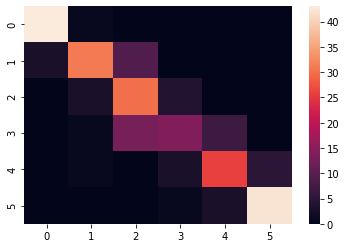

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred))

Regression Model

In [ ]:
LR = LogisticRegression(solver='lbfgs')
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

In [ ]:
evaluate(y_test, y_pred)

CONFUSION MATRIX:
[[44  0  0  0  0  0]
 [ 3 31  9  0  0  0]
 [ 0  3 33  1  0  0]
 [ 0  1  7 13 14  0]
 [ 0  0  0  1 32  2]
 [ 0  0  0  0  3 43]]
ACCURACY SCORE:
0.8167
CLASSIFICATION REPORT:
	Precision: 0.8284
	Recall: 0.8056
	F1_Score: 0.7927


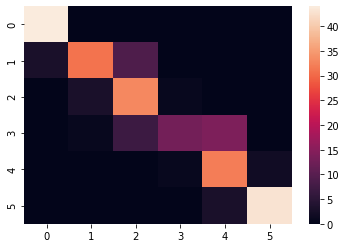

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred))

In [ ]:
y_pred1 = LR.predict(test[['AvgFreq','AvgWordDiffic','ReadScore','NumOfCog']])

In [ ]:
red1 = RF.predict(test[['AvgFreq','AvgWordDiffic','ReadScore','NumOfCog']])